Dataset: Healthcare Dabetics

In [ ]:
pip install dmba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 34.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix

from dmba import classificationSummary
from dmba import plotDecisionTree
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import statsmodels.formula.api as smf
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

Colab environment detected.


**Data preparation and processing**

In [ ]:
data = pd.read_csv('Healthcare-Diabetes.csv')

In [ ]:
data.shape

(2768, 10)

In [ ]:
df = data.drop(columns = ['Id'])

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2768 non-null   int64  
 1   Glucose                   2768 non-null   int64  
 2   BloodPressure             2768 non-null   int64  
 3   SkinThickness             2768 non-null   int64  
 4   Insulin                   2768 non-null   int64  
 5   BMI                       2768 non-null   float64
 6   DiabetesPedigreeFunction  2768 non-null   float64
 7   Age                       2768 non-null   int64  
 8   Outcome                   2768 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 194.8 KB
None


In [ ]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [ ]:
df.isnull().sum()

Pregnancies                    0
Glucose                       18
BloodPressure                125
SkinThickness                800
Insulin                     1330
BMI                           39
DiabetesPedigreeFunction       0
Age                            0
Outcome                        0
dtype: int64

In [ ]:
def median_target(var):
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

columns = df.columns.drop("Outcome")

for column in columns:
    median_values = median_target(column)
    df.loc[(df['Outcome'] == 0) & (df[column].isnull()), column] = median_values[column][0]
    df.loc[(df['Outcome'] == 1) & (df[column].isnull()), column] = median_values[column][1]

In [ ]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,168.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,105.0,26.6,0.351,31,0
2,8,183.0,64.0,32.0,168.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


Outlier Observation

In [ ]:
for feature in df:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    if df[(df[feature] > upper)].any(axis=None):
        print(feature, "yes")
    else:
        print(feature, "no")

Pregnancies yes
Glucose no
BloodPressure yes
SkinThickness yes
Insulin yes
BMI yes
DiabetesPedigreeFunction yes
Age yes
Outcome no


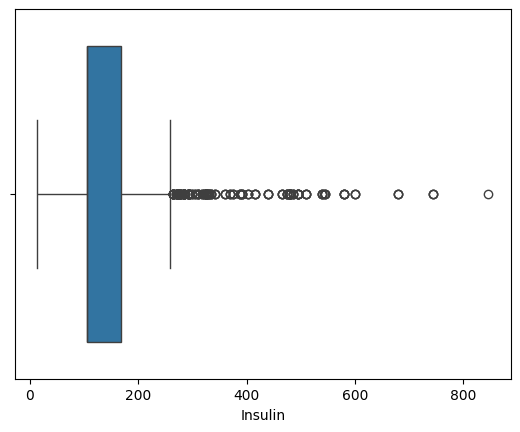

In [ ]:
import seaborn as sns
sns.boxplot(x = df["Insulin"]);

In [ ]:
Q1 = df.Insulin.quantile(0.25)
Q3 = df.Insulin.quantile(0.75)
IQR = Q3-Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
df.loc[df["Insulin"] > upper,"Insulin"] = upper


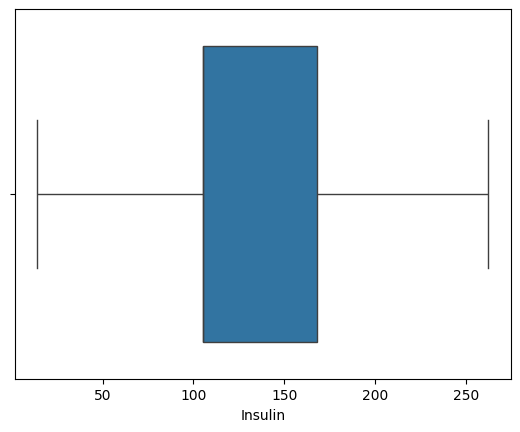

In [ ]:

import seaborn as sns
sns.boxplot(x = df["Insulin"]);

In [ ]:
#Local Outlier Factor
from sklearn.neighbors import LocalOutlierFactor
lof =LocalOutlierFactor(n_neighbors= 10)
lof.fit_predict(df)

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
df_scores = lof.negative_outlier_factor_
np.sort(df_scores)[0:30]

array([-2.90201786, -2.90201786, -2.90201786, -2.71864604, -2.71864604,
       -2.71864604, -2.58190911, -2.58190911, -2.20016882, -2.20016882,
       -2.20016882, -2.12685066, -2.12685066, -2.03668904, -2.03668904,
       -2.03668904, -2.03668904, -1.88385348, -1.88385348, -1.88385348,
       -1.88385348, -1.84157446, -1.84157446, -1.84157446, -1.82215989,
       -1.82215989, -1.82215989, -1.82215989, -1.78624364, -1.78624364])

In [ ]:
threshold = np.sort(df_scores)[7]
threshold

-2.5819091113762287

In [ ]:
outlier = df_scores > threshold
df = df[outlier]

In [ ]:
df.shape

(2760, 9)

In [ ]:
#percentage of data retained after removing outliers
(2751/2768)*100

99.38583815028902

**Data visualization**

array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

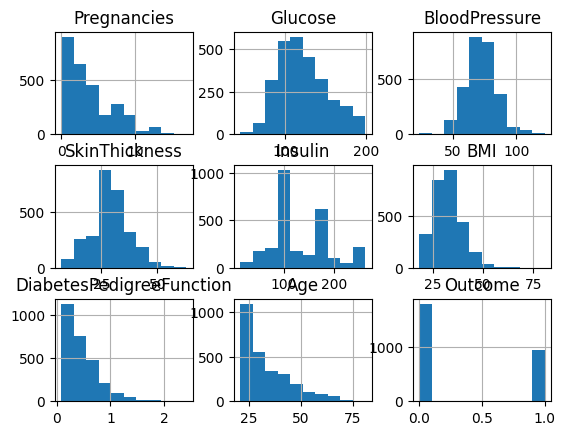

In [ ]:
#Viewing distribution of variables
df.hist()

In [ ]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.125426,0.200912,0.102704,0.102482,0.014901,-0.026568,0.550468,0.224110
Glucose,0.125426,1.000000,0.211709,0.222479,0.532699,0.233257,0.130752,0.268651,0.491830
BloodPressure,0.200912,0.211709,1.000000,0.221625,0.109717,0.269730,0.009997,0.330781,0.181324
SkinThickness,0.102704,0.222479,0.221625,1.000000,0.246555,0.565425,0.104165,0.125055,0.295363
Insulin,0.102482,0.532699,0.109717,0.246555,1.000000,0.291629,0.135000,0.151862,0.484317
BMI,0.014901,0.233257,0.269730,0.565425,0.291629,1.000000,0.145944,0.027595,0.294218
DiabetesPedigreeFunction,-0.026568,0.130752,0.009997,0.104165,0.135000,0.145944,1.000000,0.025462,0.161211
Age,0.550468,0.268651,0.330781,0.125055,0.151862,0.027595,0.025462,1.000000,0.237486
Outcome,0.224110,0.491830,0.181324,0.295363,0.484317,0.294218,0.161211,0.237486,1.000000


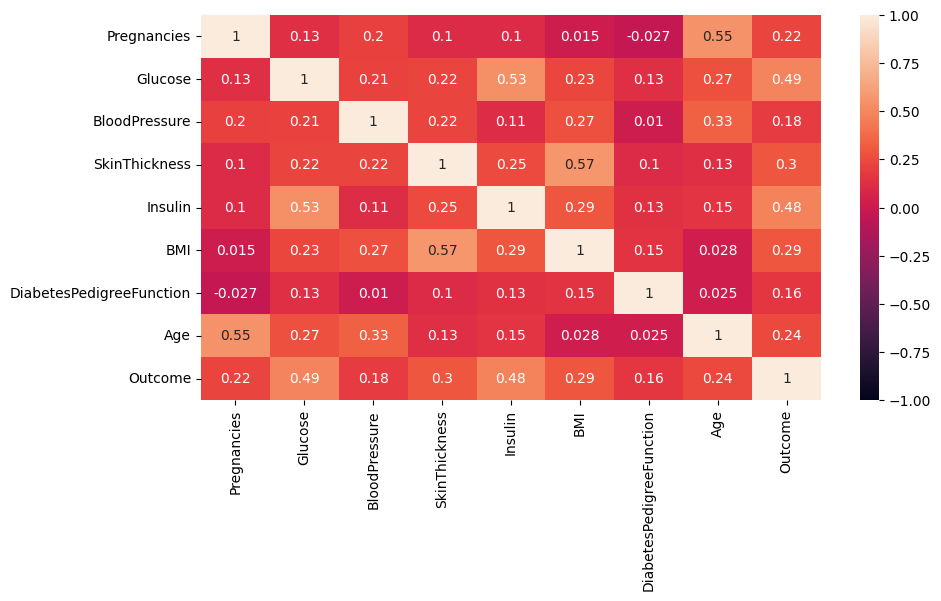

In [ ]:
plt.figure(figsize=(10, 5))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

Feature Selection and Engineering

In [ ]:
#Function to categorize BMI
def categorize_bmi(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi < 25:
        return "Normal weight"
    elif 25 <= bmi < 30:
        return "Overweight"
    elif 30 <= bmi < 35:
        return "Obesity_1"
    elif 35 <= bmi < 40:
        return "Obesity_2"
    else:
        return "Obesity_3"

df['BMICategory'] = df['BMI'].apply(categorize_bmi)

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMICategory
0,6,148.0,72.0,35.0,168.0,33.6,0.627,50,1,Obesity_1
1,1,85.0,66.0,29.0,105.0,26.6,0.351,31,0,Overweight
2,8,183.0,64.0,32.0,168.0,23.3,0.672,32,1,Normal weight
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Overweight
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Obesity_3


In [ ]:
def set_insulin(row):
    if row["Insulin"] >= 16 and row["Insulin"] <= 166:
        return "Normal"
    else:
        return "Abnormal"

df = df.assign(InsulinStatus = df.apply(set_insulin, axis=1))

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMICategory,InsulinStatus
0,6,148.0,72.0,35.0,168.0,33.6,0.627,50,1,Obesity_1,Abnormal
1,1,85.0,66.0,29.0,105.0,26.6,0.351,31,0,Overweight,Normal
2,8,183.0,64.0,32.0,168.0,23.3,0.672,32,1,Normal weight,Abnormal
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Overweight,Normal
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Obesity_3,Abnormal


In [ ]:
# Function to categorize Glucose
def categorize_glucose(glucose):
    if glucose <= 70:
        return "Low"
    elif 70 < glucose <= 99:
        return "Normal"
    elif 99 < glucose <= 126:
        return "Overweight"
    else:
        return "High"

df['GlucoseStatus'] = df['Glucose'].apply(categorize_glucose)

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMICategory,InsulinStatus,GlucoseStatus
0,6,148.0,72.0,35.0,168.0,33.6,0.627,50,1,Obesity_1,Abnormal,High
1,1,85.0,66.0,29.0,105.0,26.6,0.351,31,0,Overweight,Normal,Normal
2,8,183.0,64.0,32.0,168.0,23.3,0.672,32,1,Normal weight,Abnormal,High
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Overweight,Normal,Normal
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Obesity_3,Abnormal,High


In [ ]:
# Create a binary indicator variable for gestational diabetes
def create_GD_indicator(row):
    if row['Pregnancies'] > 0 and row['Outcome'] == 1:
        return 1  # Gestational diabetes present
    else:
        return 0  # No gestational diabetes
df['GD_Indicator'] = df.apply(create_GD_indicator, axis=1)

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMICategory,InsulinStatus,GlucoseStatus,GD_Indicator
0,6,148.0,72.0,35.0,168.0,33.6,0.627,50,1,Obesity_1,Abnormal,High,1
1,1,85.0,66.0,29.0,105.0,26.6,0.351,31,0,Overweight,Normal,Normal,0
2,8,183.0,64.0,32.0,168.0,23.3,0.672,32,1,Normal weight,Abnormal,High,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Overweight,Normal,Normal,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Obesity_3,Abnormal,High,0


In [ ]:
# Define thresholds for diastolic blood pressure
normal_dbp = (60, 80)
prehypertension_dbp = (80, 90)
hypertension_dbp = (90, 100)

def categorize_DBP(diastolic):
    if normal_dbp[0] <= diastolic <= normal_dbp[1]:
        return "Normal"
    elif prehypertension_dbp[0] <= diastolic <= prehypertension_dbp[1]:
        return "Prehypertension"
    elif hypertension_dbp[0] <= diastolic <= hypertension_dbp[1]:
        return "Hypertension"
    else:
        return "Severe_Hypertension"

# Apply the categorize_DBP function to each row of the DataFrame
df['DBP_Category'] = df['BloodPressure'].apply(categorize_DBP)

df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMICategory,InsulinStatus,GlucoseStatus,GD_Indicator,DBP_Category
0,6,148.0,72.0,35.0,168.0,33.6,0.627,50,1,Obesity_1,Abnormal,High,1,Normal
1,1,85.0,66.0,29.0,105.0,26.6,0.351,31,0,Overweight,Normal,Normal,0,Normal
2,8,183.0,64.0,32.0,168.0,23.3,0.672,32,1,Normal weight,Abnormal,High,1,Normal
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Overweight,Normal,Normal,0,Normal
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Obesity_3,Abnormal,High,0,Severe_Hypertension


To download excel dataset with new fetaures

In [ ]:
df.to_excel("output.xlsx", index=False)

Encoding

In [ ]:
hd = pd.get_dummies(df, columns =["BMICategory","InsulinStatus", "GlucoseStatus", "GD_Indicator", "DBP_Category"], drop_first = True, dtype=int)

hd.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMICategory_Obesity_1,...,BMICategory_Overweight,BMICategory_Underweight,InsulinStatus_Normal,GlucoseStatus_Low,GlucoseStatus_Normal,GlucoseStatus_Overweight,GD_Indicator_1,DBP_Category_Normal,DBP_Category_Prehypertension,DBP_Category_Severe_Hypertension
0,6,148.0,72.0,35.0,168.0,33.6,0.627,50,1,1,...,0,0,0,0,0,0,1,1,0,0
1,1,85.0,66.0,29.0,105.0,26.6,0.351,31,0,0,...,1,0,1,0,1,0,0,1,0,0
2,8,183.0,64.0,32.0,168.0,23.3,0.672,32,1,0,...,0,0,0,0,0,0,1,1,0,0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,0,...,1,0,1,0,1,0,0,1,0,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
hd.dtypes

Pregnancies                           int64
Glucose                             float64
BloodPressure                       float64
SkinThickness                       float64
Insulin                             float64
BMI                                 float64
DiabetesPedigreeFunction            float64
Age                                   int64
Outcome                               int64
BMICategory_Obesity_1                 int64
BMICategory_Obesity_2                 int64
BMICategory_Obesity_3                 int64
BMICategory_Overweight                int64
BMICategory_Underweight               int64
InsulinStatus_Normal                  int64
GlucoseStatus_Low                     int64
GlucoseStatus_Normal                  int64
GlucoseStatus_Overweight              int64
GD_Indicator_1                        int64
DBP_Category_Normal                   int64
DBP_Category_Prehypertension          int64
DBP_Category_Severe_Hypertension      int64
dtype: object

In [ ]:
hd_bin = hd[['BMICategory_Obesity_1', 'BMICategory_Obesity_2', 'BMICategory_Obesity_3', 'BMICategory_Overweight', 'BMICategory_Underweight',
                     'InsulinStatus_Normal', 'GlucoseStatus_Low', 'GlucoseStatus_Normal', 'GlucoseStatus_Overweight', 'GD_Indicator_1', 'DBP_Category_Normal',  'DBP_Category_Prehypertension', 'DBP_Category_Severe_Hypertension']]

In [ ]:
y = hd["Outcome"]
X = hd.drop(columns=["Outcome", 'BMICategory_Obesity_1', 'BMICategory_Obesity_2', 'BMICategory_Obesity_3', 'BMICategory_Overweight', 'BMICategory_Underweight',
             'InsulinStatus_Normal', 'GlucoseStatus_Low', 'GlucoseStatus_Normal', 'GlucoseStatus_Overweight', 'GD_Indicator_1','DBP_Category_Normal',  'DBP_Category_Prehypertension', 'DBP_Category_Severe_Hypertension'])
cols = X.columns


In [ ]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.0,168.0,33.6,0.627,50
1,1,85.0,66.0,29.0,105.0,26.6,0.351,31
2,8,183.0,64.0,32.0,168.0,23.3,0.672,32
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33


In [ ]:
X = pd.concat([X, hd_bin], axis = 1)
X.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,BMICategory_Obesity_1,BMICategory_Obesity_2,...,BMICategory_Overweight,BMICategory_Underweight,InsulinStatus_Normal,GlucoseStatus_Low,GlucoseStatus_Normal,GlucoseStatus_Overweight,GD_Indicator_1,DBP_Category_Normal,DBP_Category_Prehypertension,DBP_Category_Severe_Hypertension
0,6,148.0,72.0,35.0,168.0,33.6,0.627,50,1,0,...,0,0,0,0,0,0,1,1,0,0
1,1,85.0,66.0,29.0,105.0,26.6,0.351,31,0,0,...,1,0,1,0,1,0,0,1,0,0
2,8,183.0,64.0,32.0,168.0,23.3,0.672,32,0,0,...,0,0,0,0,0,0,1,1,0,0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,0,...,1,0,1,0,1,0,0,1,0,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

**Normalizing Data**

In [ ]:
scaler = StandardScaler()
features = X
labels = y
features_scaled = scaler.fit_transform(features)

In [ ]:
X.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,BMICategory_Obesity_1,BMICategory_Obesity_2,...,BMICategory_Overweight,BMICategory_Underweight,InsulinStatus_Normal,GlucoseStatus_Low,GlucoseStatus_Normal,GlucoseStatus_Overweight,GD_Indicator_1,DBP_Category_Normal,DBP_Category_Prehypertension,DBP_Category_Severe_Hypertension
0,6,148.0,72.0,35.0,168.0,33.6,0.627,50,1,0,...,0,0,0,0,0,0,1,1,0,0
1,1,85.0,66.0,29.0,105.0,26.6,0.351,31,0,0,...,1,0,1,0,1,0,0,1,0,0
2,8,183.0,64.0,32.0,168.0,23.3,0.672,32,0,0,...,0,0,0,0,0,0,1,1,0,0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,0,...,1,0,1,0,1,0,0,1,0,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
X.dtypes

Pregnancies                           int64
Glucose                             float64
BloodPressure                       float64
SkinThickness                       float64
Insulin                             float64
BMI                                 float64
DiabetesPedigreeFunction            float64
Age                                   int64
BMICategory_Obesity_1                 int64
BMICategory_Obesity_2                 int64
BMICategory_Obesity_3                 int64
BMICategory_Overweight                int64
BMICategory_Underweight               int64
InsulinStatus_Normal                  int64
GlucoseStatus_Low                     int64
GlucoseStatus_Normal                  int64
GlucoseStatus_Overweight              int64
GD_Indicator_1                        int64
DBP_Category_Normal                   int64
DBP_Category_Prehypertension          int64
DBP_Category_Severe_Hypertension      int64
dtype: object

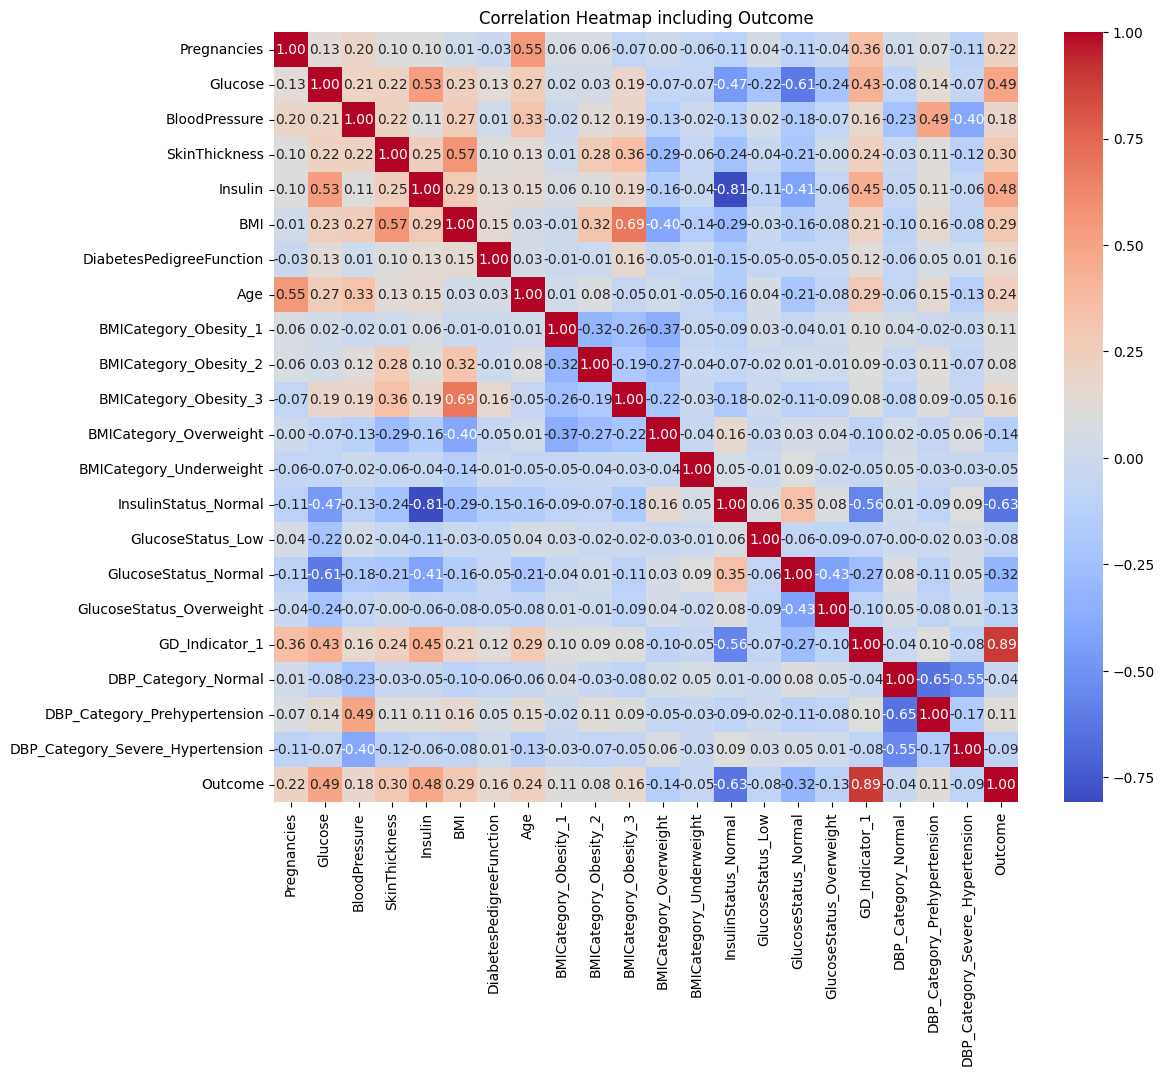

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add the outcome variable to X
hm = pd.concat([X, y], axis=1)

# Calculate the correlation matrix
corr_matrix = hm.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap including Outcome')
plt.show()


**Training and testing**

In [ ]:
train_X, valid_X, train_y, valid_y = train_test_split(X,y,test_size = 0.2)

overs = SMOTE()
unders = RandomUnderSampler(sampling_strategy = "majority")

X_train_OS, y_train_OS = overs.fit_resample(train_X, train_y)
X_train_US, y_train_US = unders.fit_resample(train_X, train_y)

In [ ]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2208 entries, 738 to 1017
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Pregnancies                       2208 non-null   int64  
 1   Glucose                           2208 non-null   float64
 2   BloodPressure                     2208 non-null   float64
 3   SkinThickness                     2208 non-null   float64
 4   Insulin                           2208 non-null   float64
 5   BMI                               2208 non-null   float64
 6   DiabetesPedigreeFunction          2208 non-null   float64
 7   Age                               2208 non-null   int64  
 8   BMICategory_Obesity_1             2208 non-null   int64  
 9   BMICategory_Obesity_2             2208 non-null   int64  
 10  BMICategory_Obesity_3             2208 non-null   int64  
 11  BMICategory_Overweight            2208 non-null   int64  
 12  BMICatego

In [ ]:
train_y.info()

<class 'pandas.core.series.Series'>
Index: 2208 entries, 738 to 1017
Series name: Outcome
Non-Null Count  Dtype
--------------  -----
2208 non-null   int64
dtypes: int64(1)
memory usage: 34.5 KB


In [ ]:
valid_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 552 entries, 2335 to 2007
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Pregnancies                       552 non-null    int64  
 1   Glucose                           552 non-null    float64
 2   BloodPressure                     552 non-null    float64
 3   SkinThickness                     552 non-null    float64
 4   Insulin                           552 non-null    float64
 5   BMI                               552 non-null    float64
 6   DiabetesPedigreeFunction          552 non-null    float64
 7   Age                               552 non-null    int64  
 8   BMICategory_Obesity_1             552 non-null    int64  
 9   BMICategory_Obesity_2             552 non-null    int64  
 10  BMICategory_Obesity_3             552 non-null    int64  
 11  BMICategory_Overweight            552 non-null    int64  
 12  BMICatego

In [ ]:
valid_y.info()

<class 'pandas.core.series.Series'>
Index: 552 entries, 2335 to 2007
Series name: Outcome
Non-Null Count  Dtype
--------------  -----
552 non-null    int64
dtypes: int64(1)
memory usage: 8.6 KB


In [ ]:
print(y_train_OS.value_counts())

Outcome
0    1444
1    1444
Name: count, dtype: int64


In [ ]:
print(y_train_US.value_counts())

Outcome
0    764
1    764
Name: count, dtype: int64


Ordinary least squares

In [ ]:
#with traditional predictor variables
lm_model = smf.ols(formula= "Outcome ~ Pregnancies + Glucose + BloodPressure + SkinThickness + Insulin + BMI + DiabetesPedigreeFunction + Age", data = df).fit()

In [ ]:
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Outcome   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     197.9
Date:                Tue, 07 May 2024   Prob (F-statistic):          5.72e-265
Time:                        04:54:01   Log-Likelihood:                -1234.2
No. Observations:                2760   AIC:                             2486.
Df Residuals:                    2751   BIC:                             2540.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.0069      0.053    -19.129      0.000      -1.110      -0.904
Pregnancies                  0.0193      0.003      7.389      0.000       0.014       0.024
Glucose                      0.0043      0.000     14.760      0.000       0.004       0.005
BloodPressure                0.0005      0.001      0.791      0.429      -0.001       0.002
SkinThickness                0.0052      0.001      5.059      0.000       0.003       0.007
Insulin                      0.0022      0.000     14.123      0.000       0.002       0.003
BMI                          0.0056      0.001      4.329      0.000       0.003       0.008
DiabetesPedigreeFunction     0.1029      0.023      4.560      0.000       0.059       0.147
Age                          0.0012      0.001      1.505      0.132      -0.000       0.003
==============================================================================
Omnibus:                       33.526   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.752
Skew:                           0.147   Prob(JB):                     2.56e-06
Kurtosis:                       2.629   Cond. No.                     1.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
#with feature engineering
lm_model = smf.ols(formula= "Outcome ~ Pregnancies + Glucose + BloodPressure + SkinThickness + Insulin + BMI + DiabetesPedigreeFunction + Age + BMICategory_Obesity_1 + BMICategory_Obesity_2 + BMICategory_Obesity_3 + BMICategory_Overweight + BMICategory_Underweight + InsulinStatus_Normal + GlucoseStatus_Low + GlucoseStatus_Normal + GlucoseStatus_Overweight + GD_Indicator_1 + DBP_Category_Normal + DBP_Category_Prehypertension + DBP_Category_Severe_Hypertension", data=hd).fit()

In [ ]:
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Outcome   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     702.7
Date:                Tue, 07 May 2024   Prob (F-statistic):               0.00
Time:                        02:23:05   Log-Likelihood:                 697.91
No. Observations:                2760   AIC:                            -1352.
Df Residuals:                    2738   BIC:                            -1222.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -0.0935      0.074     -1.271      0.204      -0.238       0.051
Pregnancies                         -0.0136      0.001     -9.914      0.000      -0.016      -0.011
Glucose                              0.0010      0.000      3.619      0.000       0.000       0.002
BloodPressure                        0.0011      0.000      2.588      0.010       0.000       0.002
SkinThickness                        0.0018      0.001      3.466      0.001       0.001       0.003
Insulin                             -0.0010      0.000     -8.805      0.000      -0.001      -0.001
BMI                                  0.0058      0.002      3.827      0.000       0.003       0.009
DiabetesPedigreeFunction             0.0336      0.011      2.956      0.003       0.011       0.056
Age                                  0.0004      0.000      0.919      0.358      -0.000       0.001
BMICategory_Obesity_1               -0.0082      0.019     -0.428      0.669      -0.046       0.029
BMICategory_Obesity_2               -0.0494      0.026     -1.923      0.055      -0.100       0.001
BMICategory_Obesity_3               -0.0501      0.037     -1.371      0.171      -0.122       0.022
BMICategory_Overweight              -0.0174      0.014     -1.202      0.230      -0.046       0.011
BMICategory_Underweight              0.0229      0.052      0.438      0.661      -0.079       0.125
InsulinStatus_Normal                -0.2149      0.014    -15.296      0.000      -0.242      -0.187
GlucoseStatus_Low                   -0.0468      0.041     -1.150      0.250      -0.127       0.033
GlucoseStatus_Normal                -0.0444      0.020     -2.245      0.025      -0.083      -0.006
GlucoseStatus_Overweight            -0.0331      0.014     -2.409      0.016      -0.060      -0.006
GD_Indicator_1                       0.8217      0.011     77.176      0.000       0.801       0.843
DBP_Category_Normal                  0.1016      0.024      4.256      0.000       0.055       0.148
DBP_Category_Prehypertension         0.0929      0.023      3.993      0.000       0.047       0.139
DBP_Category_Severe_Hypertension     0.1011      0.028      3.670      0.000       0.047       0.155
==============================================================================
Omnibus:                     1583.562   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12217.093
Skew:                           2.693   Prob(JB):                         0.00
Kurtosis:                      11.788   Cond. No.                     4.74e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is corre

#**Modelling**

**NAIVE BAYES**

In [ ]:
#Original
nb1 = GaussianNB()
nb1.fit(train_X, train_y)

pred1 = nb1.predict(valid_X)

DF1 = pd.DataFrame({"Actual": valid_y, "Predict": pred1})
print(DF1.head(10))
print()
print(classification_report(valid_y,pred1))

      Actual  Predict
2335       0        1
2095       0        0
241        0        0
2237       0        0
1431       1        1
2582       0        1
501        0        0
1373       0        0
1870       0        1
2739       0        1

              precision    recall  f1-score   support

           0       0.97      0.81      0.88       367
           1       0.71      0.96      0.82       185

    accuracy                           0.86       552
   macro avg       0.84      0.88      0.85       552
weighted avg       0.89      0.86      0.86       552



Confusion Matrix:
[[296  71]
 [  8 177]]


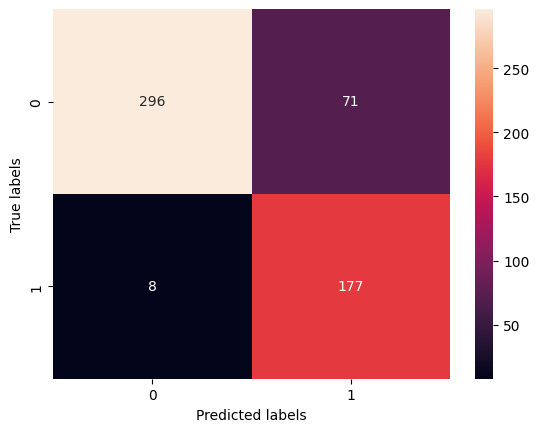

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,pred1)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
#OverSample
nb2 = GaussianNB()
nb2.fit(X_train_OS, y_train_OS)

pred2 = nb2.predict(valid_X)

DF2 = pd.DataFrame({"Actual": valid_y, "Predict": pred2})
print(DF2.head(10))
print()
print(classification_report(valid_y,pred2))

      Actual  Predict
2335       0        1
2095       0        0
241        0        0
2237       0        0
1431       1        1
2582       0        1
501        0        0
1373       0        0
1870       0        1
2739       0        1

              precision    recall  f1-score   support

           0       0.97      0.80      0.88       367
           1       0.70      0.96      0.81       185

    accuracy                           0.85       552
   macro avg       0.84      0.88      0.84       552
weighted avg       0.88      0.85      0.85       552



Confusion Matrix:
[[292  75]
 [  8 177]]


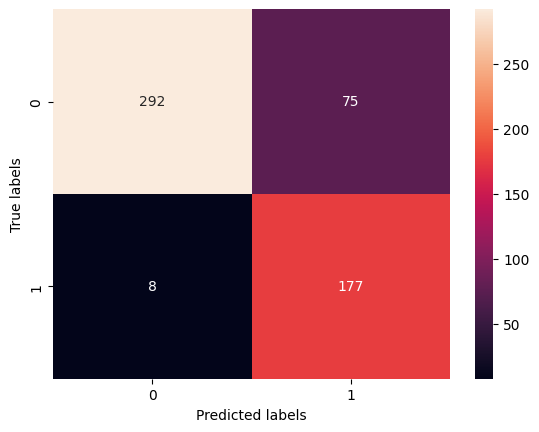

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,pred2)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
#Undersample
nb3 = GaussianNB()
nb3.fit(X_train_US, y_train_US)

pred3 = nb3.predict(valid_X)

DF3 = pd.DataFrame({"Actual": valid_y, "Predict": pred3})
print(DF3.head(10))
print()
print(classification_report(valid_y,pred3))

      Actual  Predict
2335       0        1
2095       0        0
241        0        0
2237       0        0
1431       1        1
2582       0        1
501        0        0
1373       0        0
1870       0        1
2739       0        1

              precision    recall  f1-score   support

           0       0.97      0.81      0.88       367
           1       0.71      0.96      0.82       185

    accuracy                           0.86       552
   macro avg       0.84      0.88      0.85       552
weighted avg       0.89      0.86      0.86       552



Confusion Matrix:
[[296  71]
 [  8 177]]


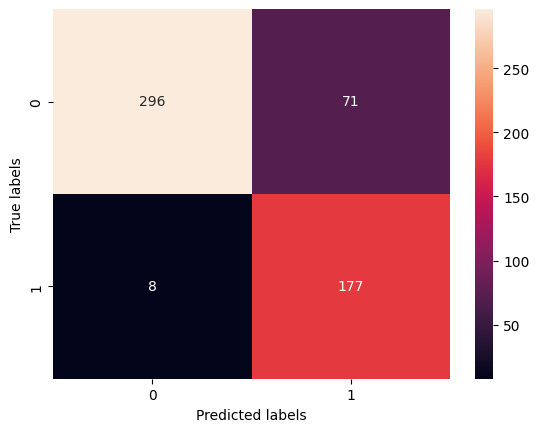

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,pred3)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

**Decicion Tree - Fully Grown**

In [ ]:
DT = DecisionTreeClassifier()
DT.fit(train_X, train_y)

DecisionTreeClassifier()

In [ ]:
tpred = DT.predict(valid_X)

DF1 = pd.DataFrame({"Actual": valid_y, "Predicted": tpred})

print(DF1.head(5))

      Actual  Predicted
2335       0          0
2095       0          0
241        0          0
2237       0          0
1431       1          1


Confusion Matrix (Accuracy 0.9928)

       Prediction
Actual   0   1
     0 367   0
     1   4 181


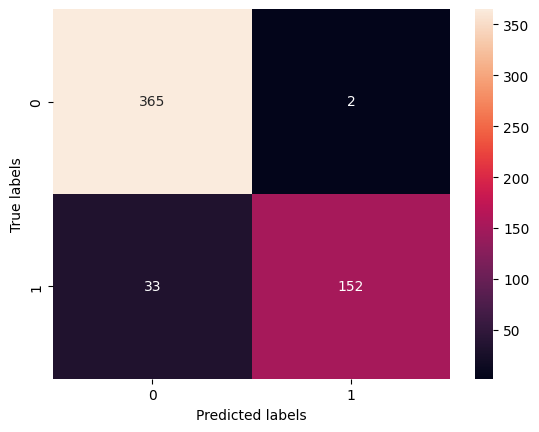

In [ ]:
classificationSummary(valid_y, tpred)

sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
print(classification_report(valid_y, tpred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       367
           1       1.00      0.98      0.99       185

    accuracy                           0.99       552
   macro avg       0.99      0.99      0.99       552
weighted avg       0.99      0.99      0.99       552



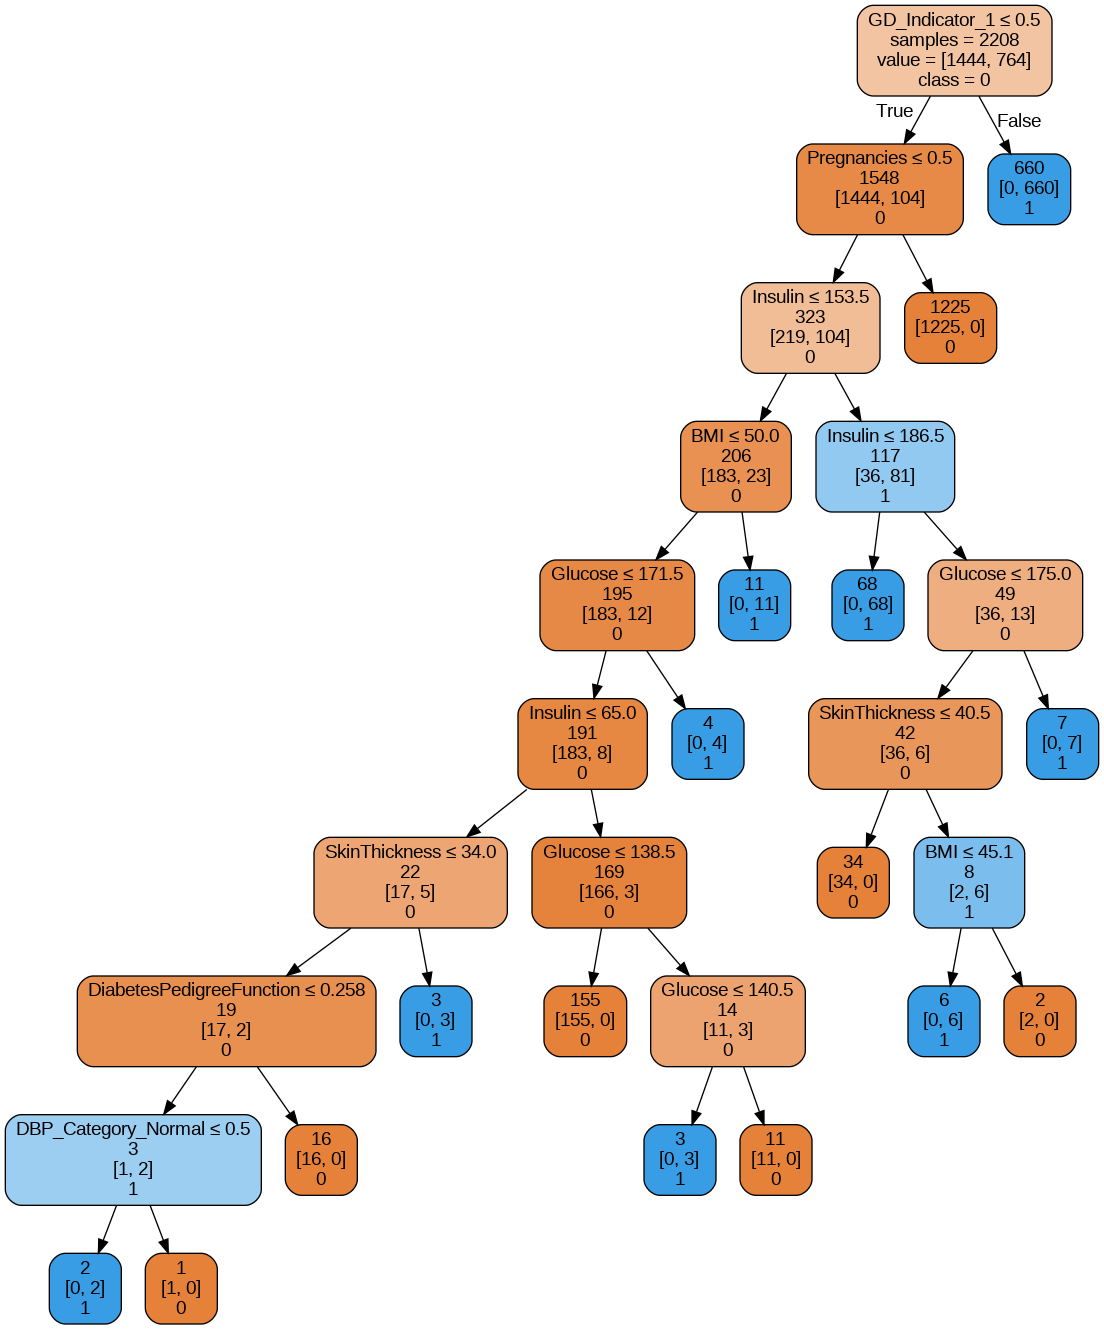

In [ ]:
plotDecisionTree(DT, feature_names = train_X.columns,
                 class_names = DT.classes_)

In [ ]:
#Oversample

O_DT = DecisionTreeClassifier(max_depth = 10, min_impurity_decrease = 0,
                              min_samples_split = 0.2)

O_DT.fit(X_train_OS, y_train_OS)

predsOS = O_DT.predict(valid_X)

DF3 = pd.DataFrame({"Actual": valid_y, "Predicted": predsOS})

print(DF3.head(10))

print()
print(classification_report(valid_y, predsOS))

      Actual  Predicted
2335       0          1
2095       0          0
241        0          0
2237       0          0
1431       1          1
2582       0          0
501        0          0
1373       0          0
1870       0          0
2739       0          0

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       367
           1       0.99      0.82      0.90       185

    accuracy                           0.94       552
   macro avg       0.95      0.91      0.93       552
weighted avg       0.94      0.94      0.93       552



Confusion Matrix:
[[365   2]
 [ 33 152]]


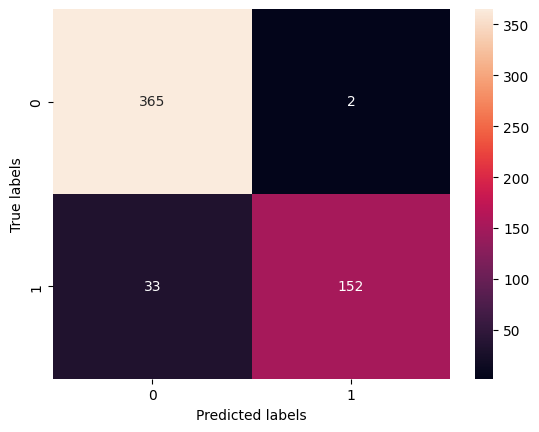

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y, predsOS)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
#undersampling

U_DT = DecisionTreeClassifier(max_depth = 10, min_impurity_decrease = 0,
                              min_samples_split = 20)

U_DT.fit(X_train_US, y_train_US)

predsUS = U_DT.predict(valid_X)

DF4 = pd.DataFrame({"Actual": valid_y,
                    "Predicted": predsUS})

print(DF4.head(10))

print()

print(classification_report(valid_y, predsUS))

      Actual  Predicted
2335       0          0
2095       0          0
241        0          0
2237       0          0
1431       1          1
2582       0          0
501        0          0
1373       0          0
1870       0          0
2739       0          0

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       367
           1       0.97      0.97      0.97       185

    accuracy                           0.98       552
   macro avg       0.98      0.98      0.98       552
weighted avg       0.98      0.98      0.98       552



Confusion Matrix:
[[361   6]
 [  6 179]]


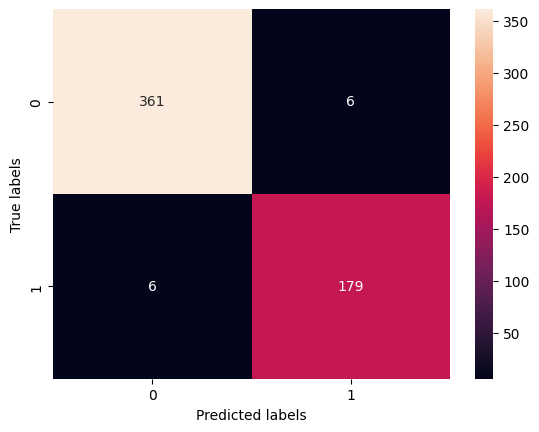

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,predsUS)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

**Decision Tree- Pruned**

In [ ]:
#first let us try cross-validation
from sklearn.model_selection import cross_val_score

In [ ]:
mls = cross_val_score(DT, train_X, train_y, cv = 5)
print(f"Accuracies: {mls.round(3)}")

Accuracies: [0.995 0.998 1.    1.    1.   ]


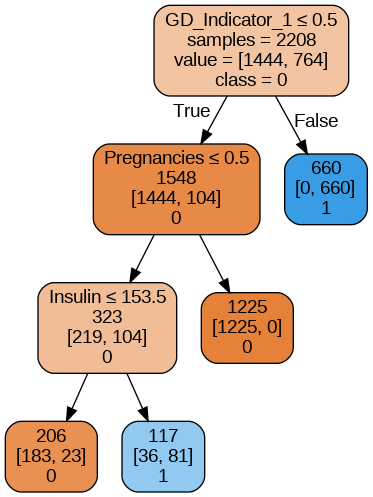

In [ ]:
s_DT = DecisionTreeClassifier(max_depth = 3, min_samples_split = 20,
                              min_impurity_decrease = 0.01, random_state = 1)
s_DT.fit(train_X, train_y)

plotDecisionTree(s_DT, feature_names = train_X.columns,
                 class_names = s_DT.classes_)

In [ ]:
#Create a smaller tree:
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {'max_depth': [5, 10, 15, 20],
          'min_samples_split': [20, 40, 60, 80, 100],
          'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01]}

gs = GridSearchCV(DecisionTreeClassifier(random_state = 1),
                  params, cv = 5)

gs.fit(train_X, train_y)
print(f"Score: {gs.best_score_}")
print(f'Parameters: {gs.best_params_}')

Score: 0.9950185202286044
Parameters: {'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 20}


In [ ]:
preds1 = gs.predict(valid_X)

In [ ]:
hd2 = pd.DataFrame({'Actual': valid_y,
                    'Predicted': preds1})

In [ ]:
hd2.head(10)

,Actual,Predicted
2335,0,0
2095,0,0
241,0,0
2237,0,0
1431,1,1
2582,0,0
501,0,0
1373,0,0
1870,0,0
2739,0,0


In [ ]:
print(classification_report(valid_y, preds1))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       367
           1       0.99      0.97      0.98       185

    accuracy                           0.99       552
   macro avg       0.99      0.99      0.99       552
weighted avg       0.99      0.99      0.99       552



Confusion Matrix:
[[366   1]
 [  5 180]]


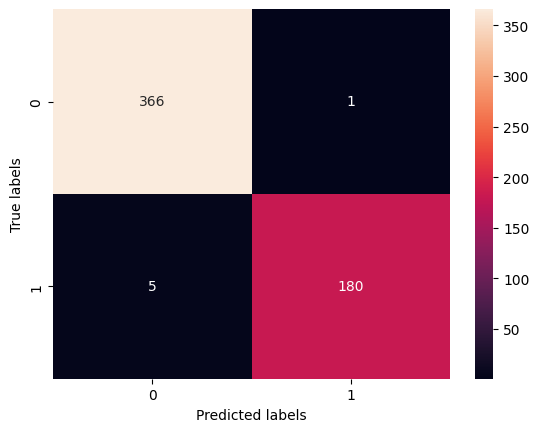

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y, preds1)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
#Oversample
O_DT = DecisionTreeClassifier(max_depth = 10, min_impurity_decrease = 0,
                              min_samples_split = 20)

O_DT.fit(X_train_OS, y_train_OS)

predsOS = O_DT.predict(valid_X)

DF3 = pd.DataFrame({"Actual": valid_y,
                    "Predicted": predsOS})

print(DF3.head(10))

print()

print(classification_report(valid_y, predsOS))


      Actual  Predicted
2335       0          0
2095       0          0
241        0          0
2237       0          0
1431       1          1
2582       0          0
501        0          0
1373       0          0
1870       0          0
2739       0          0

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       367
           1       0.98      0.97      0.98       185

    accuracy                           0.99       552
   macro avg       0.99      0.98      0.98       552
weighted avg       0.99      0.99      0.99       552



Confusion Matrix:
[[364   3]
 [  5 180]]


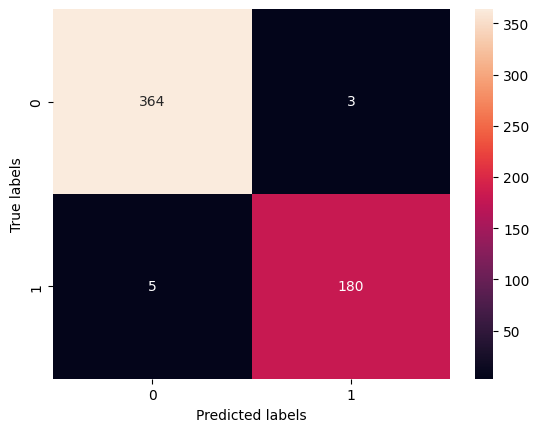

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,predsOS)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
#Undersample
U_DT = DecisionTreeClassifier(max_depth = 10, min_impurity_decrease = 0,
                              min_samples_split = 20)

U_DT.fit(X_train_US, y_train_US)

predsUS = U_DT.predict(valid_X)

DF4 = pd.DataFrame({"Actual": valid_y,
                    "Predicted": predsUS})

print(DF4.head(10))

print()

print(classification_report(valid_y, predsUS))

      Actual  Predicted
2335       0          0
2095       0          0
241        0          0
2237       0          0
1431       1          1
2582       0          0
501        0          0
1373       0          0
1870       0          0
2739       0          0

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       367
           1       0.97      0.97      0.97       185

    accuracy                           0.98       552
   macro avg       0.98      0.98      0.98       552
weighted avg       0.98      0.98      0.98       552



Confusion Matrix:
[[361   6]
 [  6 179]]


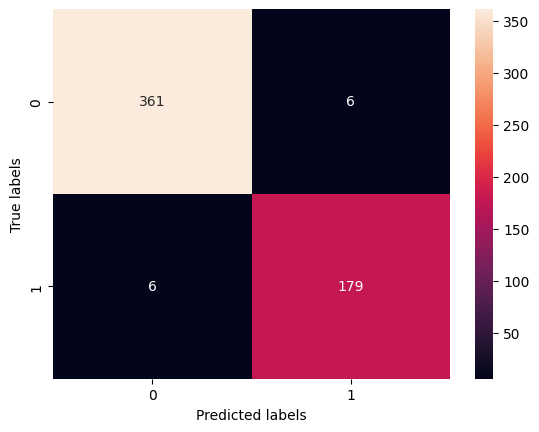

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,predsUS)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

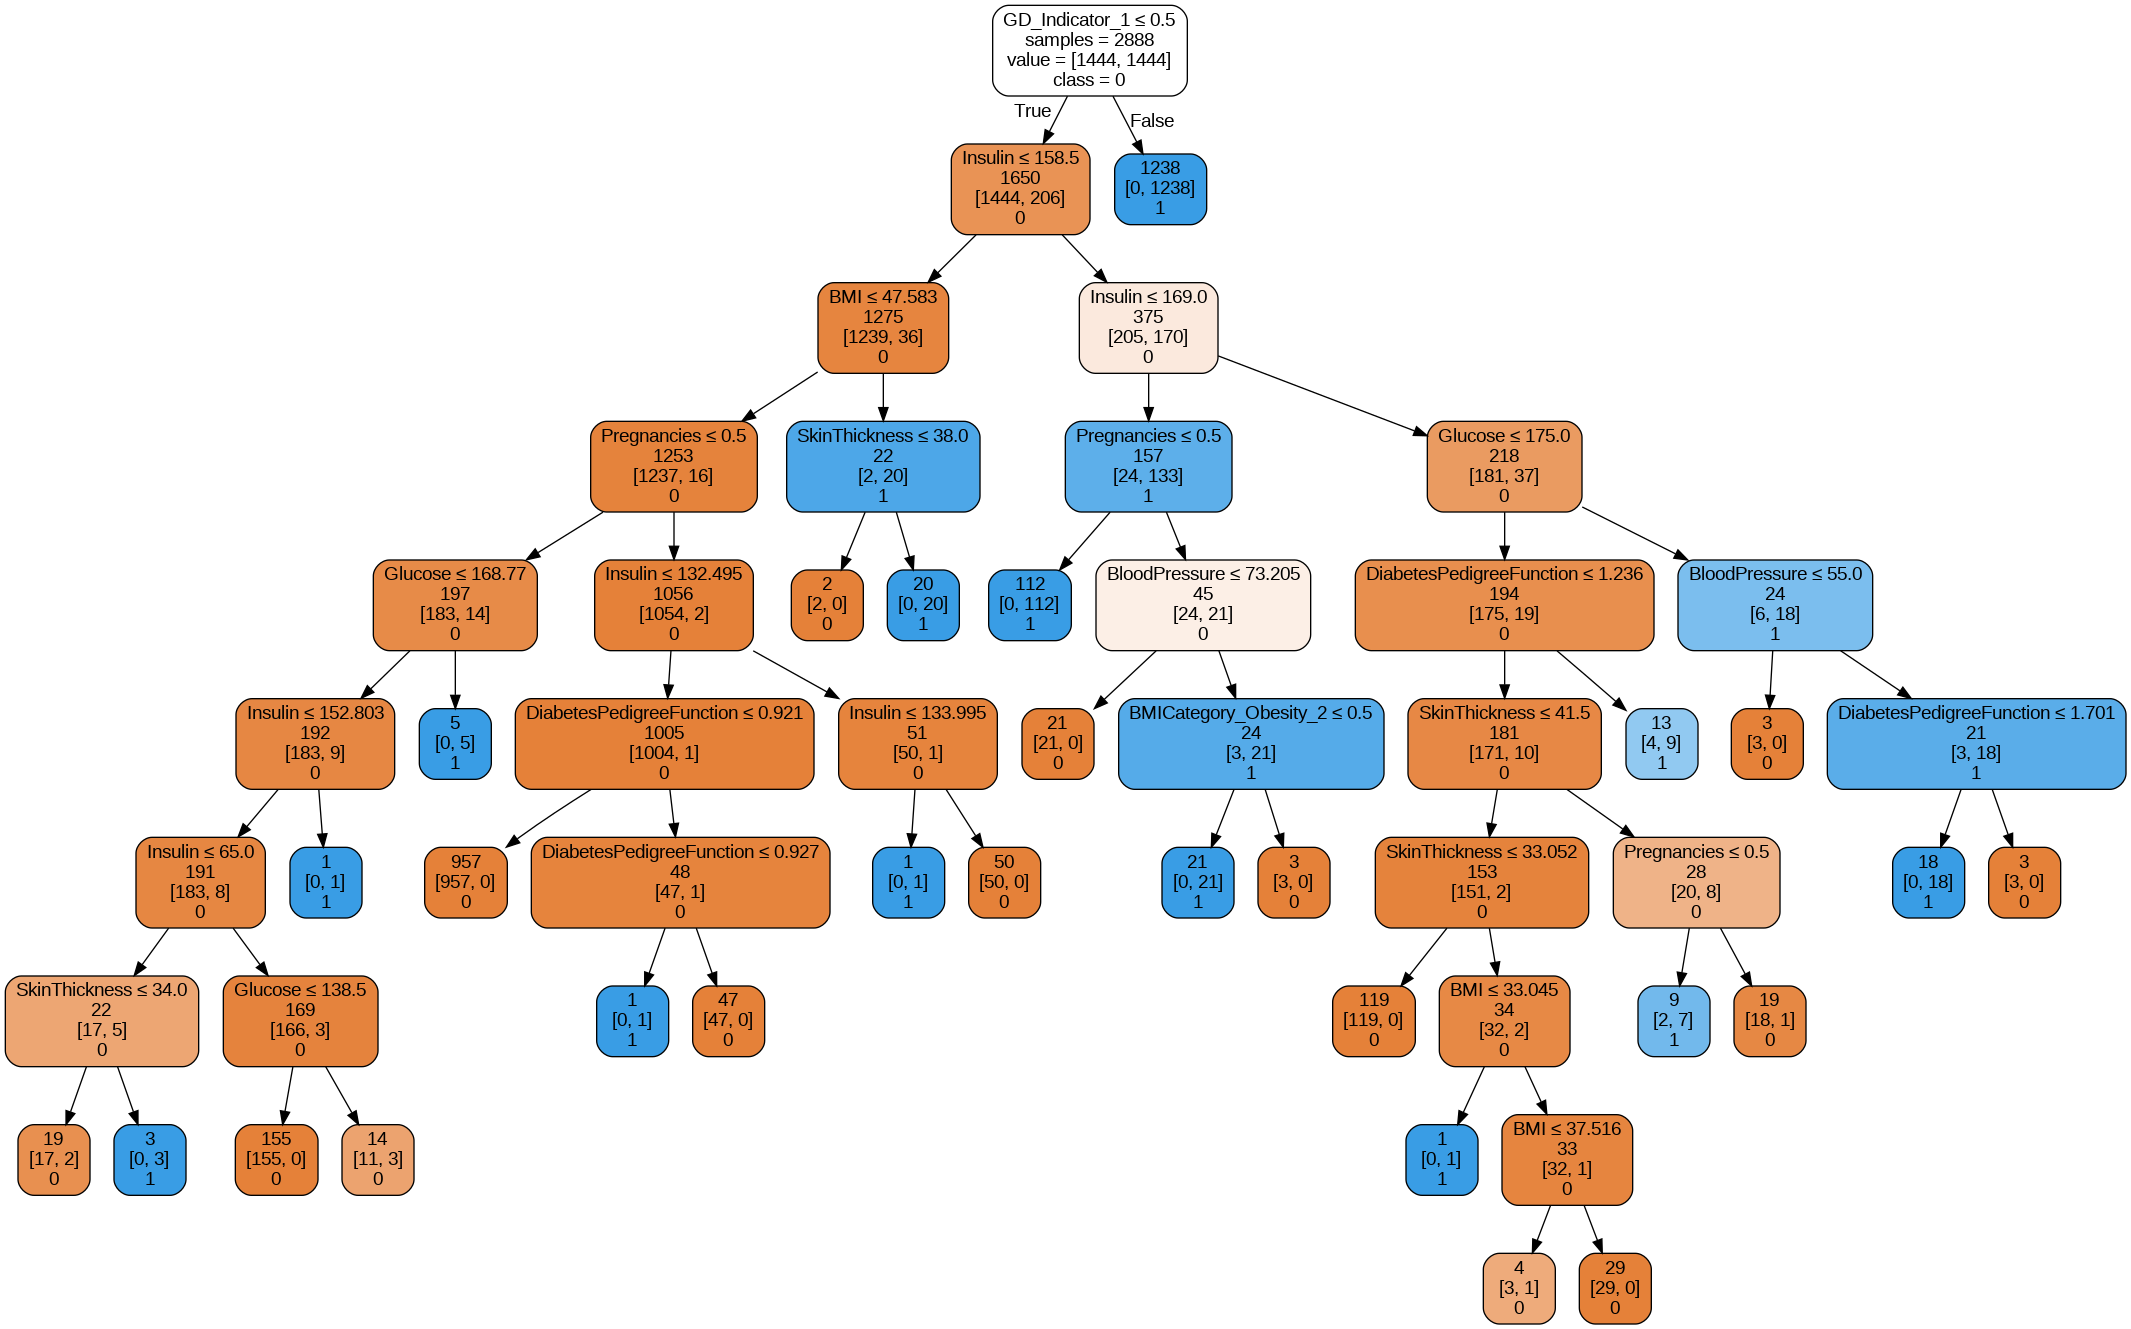

In [ ]:
plotDecisionTree(O_DT, feature_names = train_X.columns,
                 class_names = O_DT.classes_)

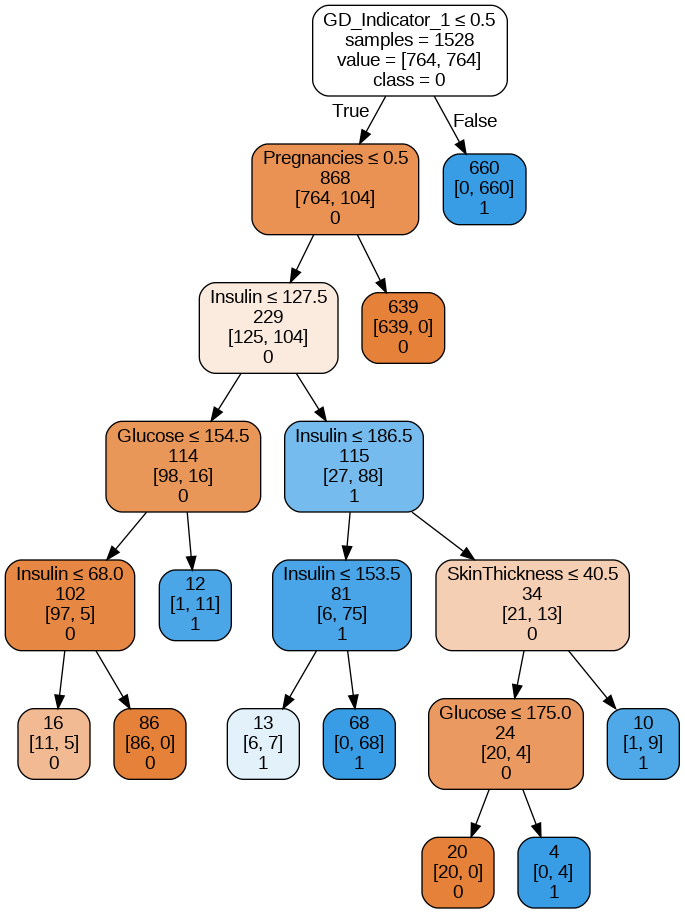

In [ ]:
plotDecisionTree(U_DT, feature_names = train_X.columns,
                 class_names = U_DT.classes_)

Logistic Regression


In [ ]:
lg = LogisticRegression()

lg.fit(train_X, train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
lpred = lg.predict(valid_X)
lgprob = lg.predict_proba(valid_X)

In [ ]:
print(lpred)

[0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 0
 0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0
 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1
 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0
 1 1 1 0 0 0 1 1 0 1 0 0 

In [ ]:
probabilities = pd.DataFrame({'p(0)': [p[0] for p in lgprob],
                             'p(1)': [p[1] for p in lgprob]})
print(probabilities)

         p(0)      p(1)
0    0.926604  0.073396
1    0.988307  0.011693
2    0.978469  0.021531
3    0.957811  0.042189
4    0.026437  0.973563
..        ...       ...
547  0.004939  0.995061
548  0.675164  0.324836
549  0.989297  0.010703
550  0.968015  0.031985
551  0.053444  0.946556

[552 rows x 2 columns]


In [ ]:
lgresult = pd.DataFrame({'Actual': valid_y, 'Predicted': lpred})
print(lgresult.head(10))

      Actual  Predicted
2335       0          0
2095       0          0
241        0          0
2237       0          0
1431       1          1
2582       0          0
501        0          0
1373       0          0
1870       0          0
2739       0          1


In [ ]:
print(train_y.dtype)
print(valid_y.dtype)

int64
int64


In [ ]:
classificationSummary(train_y, lg.predict(train_X))

Confusion Matrix (Accuracy 0.9665)

       Prediction
Actual    0    1
     0 1427   17
     1   57  707


In [ ]:
cm = confusion_matrix(valid_y, lpred)
print(cm)

[[360   7]
 [ 20 165]]


In [ ]:
valid_y.value_counts()

Outcome
0    367
1    185
Name: count, dtype: int64

In [ ]:
#orginal
print(classification_report(valid_y,lpred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       367
           1       0.96      0.89      0.92       185

    accuracy                           0.95       552
   macro avg       0.95      0.94      0.94       552
weighted avg       0.95      0.95      0.95       552



Confusion Matrix:
[[360   7]
 [ 20 165]]


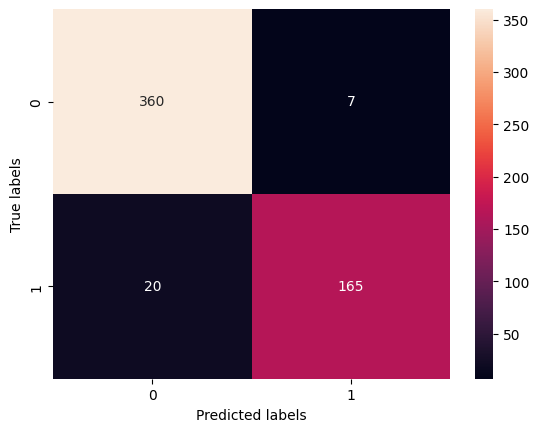

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,lpred)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
#oversampling

lg_OS = LogisticRegression(penalty = 'l2', C = 1e42, solver = 'liblinear')
lg_OS.fit(X_train_OS, y_train_OS)

lpredOS = lg_OS.predict(valid_X)

In [ ]:
probs2 = pd.DataFrame({"Actual": valid_y, "Predictions": lpredOS})

print(probs2.head(10))

      Actual  Predictions
2335       0            0
2095       0            0
241        0            0
2237       0            0
1431       1            1
2582       0            0
501        0            0
1373       0            0
1870       0            0
2739       0            1


In [ ]:
classificationSummary(valid_y, lpredOS)

Confusion Matrix (Accuracy 0.9674)

       Prediction
Actual   0   1
     0 358   9
     1   9 176


In [ ]:
print(classification_report(valid_y, lpredOS))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       367
           1       0.95      0.95      0.95       185

    accuracy                           0.97       552
   macro avg       0.96      0.96      0.96       552
weighted avg       0.97      0.97      0.97       552



In [ ]:
#undersampling

lgUS = LogisticRegression(penalty = 'l2', C = 1e42, solver = 'liblinear')
lgUS.fit(X_train_US, y_train_US)

lpredUS = lgUS.predict(valid_X)

In [ ]:
predUS = pd.DataFrame({"Actual": valid_y, "Predictions": lpredUS})
print(predUS.head(5))

      Actual  Predictions
2335       0            0
2095       0            0
241        0            0
2237       0            0
1431       1            1


In [ ]:
print(classificationSummary(valid_y, lpredUS))

print()

print(classification_report(valid_y, lpredUS))

Confusion Matrix (Accuracy 0.9783)

       Prediction
Actual   0   1
     0 361   6
     1   6 179
None

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       367
           1       0.97      0.97      0.97       185

    accuracy                           0.98       552
   macro avg       0.98      0.98      0.98       552
weighted avg       0.98      0.98      0.98       552



KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier()
knn_classifier.fit(train_X, train_y)
knn_predictions = knn_classifier.predict(valid_X)

In [ ]:
#original
k1 = KNeighborsClassifier(n_neighbors = 5)
k1.fit(train_X, train_y)

pred1 = k1.predict(valid_X)

DF1 = pd.DataFrame({"Actual": valid_y, "Predict": pred1})

print(DF1.head(5))
print()
print(classification_report(valid_y, pred1))

      Actual  Predict
2335       0        1
2095       0        0
241        0        0
2237       0        0
1431       1        1

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       367
           1       0.85      0.89      0.87       185

    accuracy                           0.91       552
   macro avg       0.90      0.91      0.90       552
weighted avg       0.91      0.91      0.91       552



Confusion Matrix:
[[337  30]
 [ 20 165]]


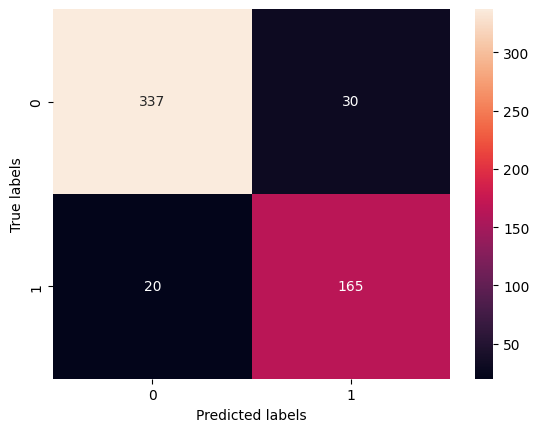

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,pred1)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
#Oversample
k2 = KNeighborsClassifier(n_neighbors = 5)
k2.fit(X_train_OS, y_train_OS)

pred2 = k2.predict(valid_X)

DF2 = pd.DataFrame({"Actual": valid_y, "Predict": pred2})

print(DF2.head(5))
print()
print(classification_report(valid_y, pred2))

      Actual  Predict
2335       0        1
2095       0        0
241        0        0
2237       0        0
1431       1        1

              precision    recall  f1-score   support

           0       0.96      0.91      0.94       367
           1       0.84      0.93      0.88       185

    accuracy                           0.92       552
   macro avg       0.90      0.92      0.91       552
weighted avg       0.92      0.92      0.92       552



Confusion Matrix:
[[334  33]
 [ 13 172]]


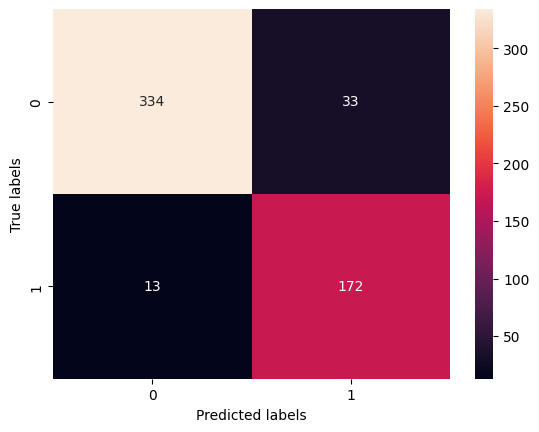

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,pred2)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
#Undersample
k3 = KNeighborsClassifier(n_neighbors = 5)
k3.fit(X_train_US, y_train_US)

pred3 = k3.predict(valid_X)

DF3 = pd.DataFrame({"Actual": valid_y, "Predict": pred3})

print(DF3.head(5))
print()
print(classification_report(valid_y, pred3))

      Actual  Predict
2335       0        1
2095       0        0
241        0        0
2237       0        0
1431       1        1

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       367
           1       0.78      0.95      0.85       185

    accuracy                           0.89       552
   macro avg       0.87      0.91      0.88       552
weighted avg       0.91      0.89      0.89       552



Confusion Matrix:
[[316  51]
 [  9 176]]


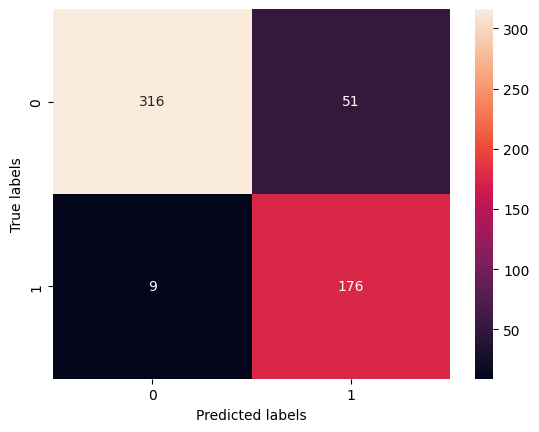

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,pred3)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
#list of different neighbors
neighbors = [4, 3, 7, 13, 19]

for k in neighbors:
  # original
  print("ORIGINAL")
  k1 = KNeighborsClassifier(n_neighbors = k)
  k1.fit(train_X, train_y)
  pred1 = k1.predict(valid_X)
  DF1 = pd.DataFrame({"Actual": valid_y, "Predict": pred1})
  print(f"k: {k}")
  print(classification_report(valid_y, pred1))
  print()

  # Oversample
  print("OVERSAMPLE")
  k2 = KNeighborsClassifier(n_neighbors = k)
  k2.fit(X_train_OS, y_train_OS)
  pred2 = k2.predict(valid_X)
  DF2 = pd.DataFrame({"Actual": valid_y, "Predict": pred2})
  print(classification_report(valid_y, pred2))
  print()

  # undersample
  print("UNDERSAMPLE")
  k3 = KNeighborsClassifier(n_neighbors = k)
  k3.fit(X_train_US, y_train_US)
  pred3 = k3.predict(valid_X)
  DF3 = pd.DataFrame({"Actual": valid_y, "Predict": pred3})
  print(classification_report(valid_y, pred3))
  print()


ORIGINAL
k: 4
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       367
           1       0.95      0.88      0.91       185

    accuracy                           0.94       552
   macro avg       0.94      0.93      0.94       552
weighted avg       0.94      0.94      0.94       552


OVERSAMPLE
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       367
           1       0.95      0.93      0.94       185

    accuracy                           0.96       552
   macro avg       0.96      0.95      0.96       552
weighted avg       0.96      0.96      0.96       552


UNDERSAMPLE
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       367
           1       0.84      0.94      0.89       185

    accuracy                           0.92       552
   macro avg       0.90      0.92      0.91       552
weighted avg       0.92      0.92  

Bagging

In [ ]:
#0rginal

BG = BaggingClassifier(DecisionTreeClassifier(random_state = 1),
                       n_estimators = 100, random_state = 1)
BG.fit(train_X, train_y)

pred2 = BG.predict(valid_X)
print(classification_report(valid_y, pred2))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       367
           1       1.00      0.98      0.99       185

    accuracy                           0.99       552
   macro avg       0.99      0.99      0.99       552
weighted avg       0.99      0.99      0.99       552



Confusion Matrix:
[[367   0]
 [  4 181]]


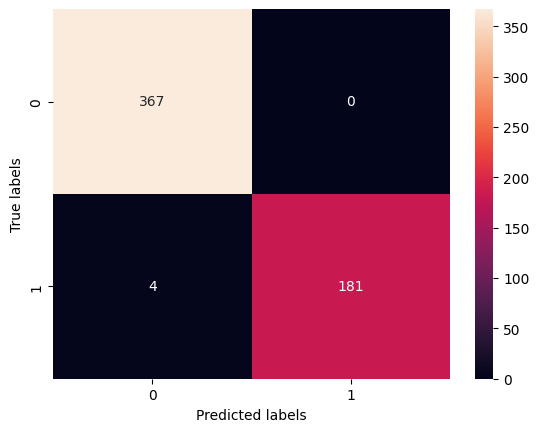

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,pred2)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
#Oversample

smote = SMOTE(random_state=1)
train_X_resampled, train_y_resampled = smote.fit_resample(train_X, train_y)
BG.fit(train_X_resampled, train_y_resampled)
pred2 = BG.predict(valid_X)
print(classification_report(valid_y, pred2))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       367
           1       0.99      0.98      0.98       185

    accuracy                           0.99       552
   macro avg       0.99      0.99      0.99       552
weighted avg       0.99      0.99      0.99       552



Confusion Matrix:
[[365   2]
 [  4 181]]


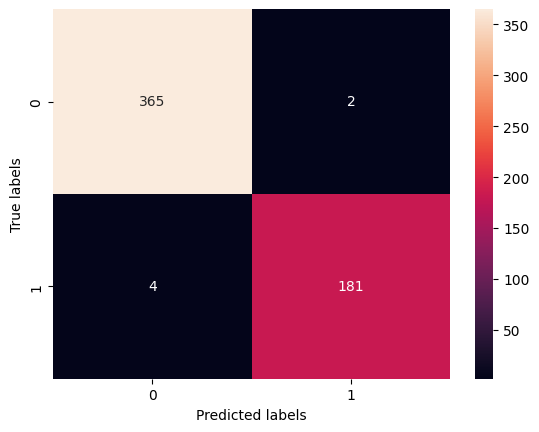

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,pred2)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
#undersample

rus = RandomUnderSampler(random_state=1)
train_X_resampled, train_y_resampled = rus.fit_resample(train_X, train_y)
BG.fit(train_X_resampled, train_y_resampled)
pred2 = BG.predict(valid_X)
print(classification_report(valid_y, pred2))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       367
           1       0.98      0.98      0.98       185

    accuracy                           0.99       552
   macro avg       0.99      0.99      0.99       552
weighted avg       0.99      0.99      0.99       552



Confusion Matrix:
[[364   3]
 [  3 182]]


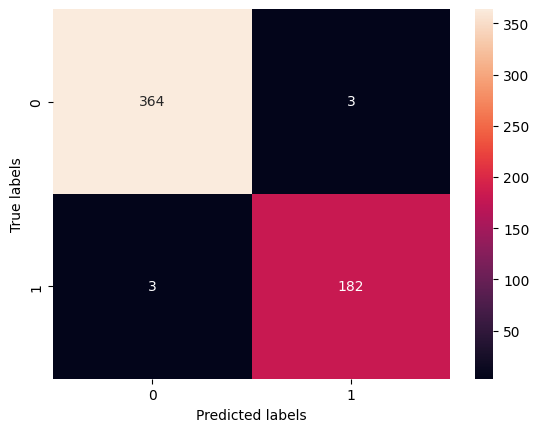

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,pred2)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Boosting

In [ ]:
#Orginal

BT = AdaBoostClassifier(DecisionTreeClassifier(random_state=1),
                        n_estimators = 100, random_state=1)
BT.fit(train_X,train_y)

pred3 = BT.predict(valid_X)
print(classification_report(valid_y,pred3))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       367
           1       1.00      0.98      0.99       185

    accuracy                           0.99       552
   macro avg       1.00      0.99      0.99       552
weighted avg       0.99      0.99      0.99       552



In [ ]:
#Oversample
smote = SMOTE(random_state=1)
train_X_resampled, train_y_resampled = smote.fit_resample(train_X, train_y)

BT.fit(train_X_resampled, train_y_resampled)

pred3 = BT.predict(valid_X)

print(classification_report(valid_y, pred3))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       367
           1       0.99      0.98      0.99       185

    accuracy                           0.99       552
   macro avg       0.99      0.99      0.99       552
weighted avg       0.99      0.99      0.99       552



Confusion Matrix:
[[365   2]
 [  3 182]]


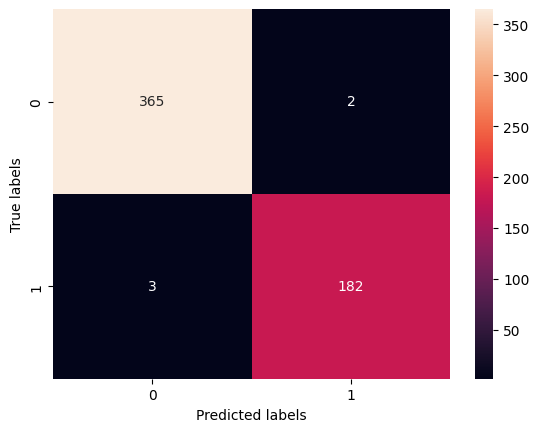

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,pred3)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
#Undersample

rus = RandomUnderSampler(random_state=1)
train_X_resampled, train_y_resampled = rus.fit_resample(train_X, train_y)

BT.fit(train_X_resampled, train_y_resampled)

pred3 = BT.predict(valid_X)

print(classification_report(valid_y, pred3))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       367
           1       0.98      0.98      0.98       185

    accuracy                           0.99       552
   macro avg       0.99      0.99      0.99       552
weighted avg       0.99      0.99      0.99       552



Confusion Matrix:
[[364   3]
 [  4 181]]


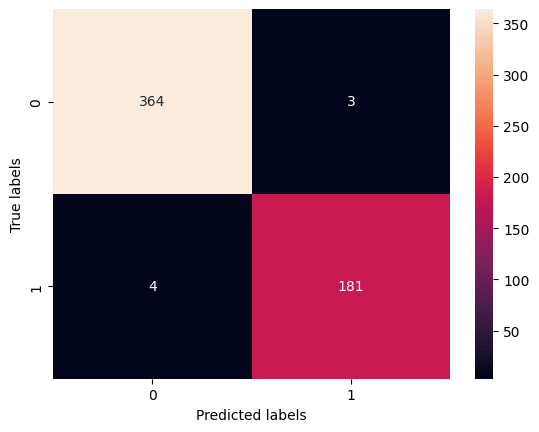

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,pred3)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Random Forest

In [ ]:
#Original
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators = 500, random_state = 1)
RF.fit(train_X, train_y)

pred4 = RF.predict(valid_X)
print(classification_report(valid_y, pred4))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       367
           1       1.00      0.98      0.99       185

    accuracy                           0.99       552
   macro avg       0.99      0.99      0.99       552
weighted avg       0.99      0.99      0.99       552



Confusion Matrix:
[[367   0]
 [  4 181]]


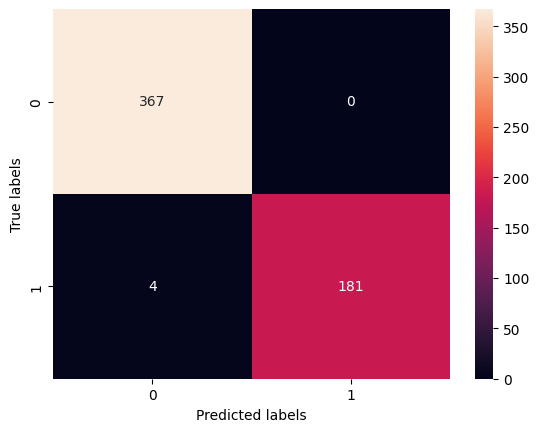

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,pred4)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
# oversample
smote = SMOTE(random_state=1)
train_X_resampled, train_y_resampled = smote.fit_resample(train_X, train_y)

RF.fit(train_X_resampled, train_y_resampled)

pred4 = RF.predict(valid_X)

print(classification_report(valid_y, pred4))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       367
           1       0.99      0.98      0.98       185

    accuracy                           0.99       552
   macro avg       0.99      0.99      0.99       552
weighted avg       0.99      0.99      0.99       552



Confusion Matrix:
[[365   2]
 [  4 181]]


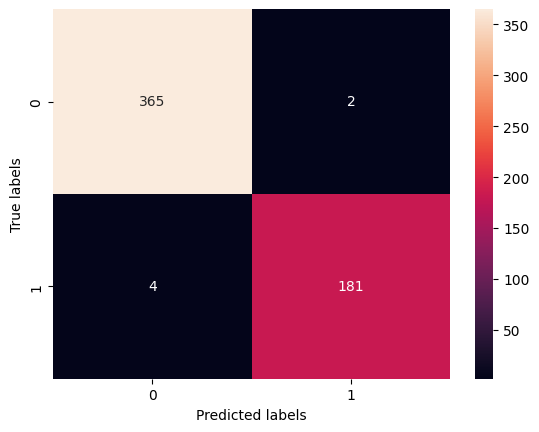

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,pred4)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
# Undersample
rus = RandomUnderSampler(random_state=1)
train_X_resampled, train_y_resampled = rus.fit_resample(train_X, train_y)
RF.fit(train_X_resampled, train_y_resampled)
pred4 = RF.predict(valid_X)
print(classification_report(valid_y, pred4))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       367
           1       1.00      0.98      0.99       185

    accuracy                           0.99       552
   macro avg       0.99      0.99      0.99       552
weighted avg       0.99      0.99      0.99       552



Confusion Matrix:
[[367   0]
 [  4 181]]


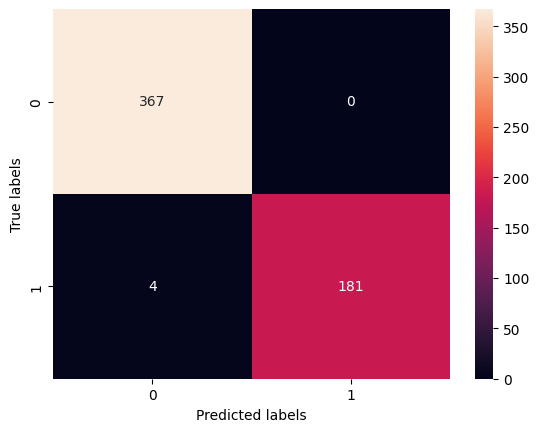

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,pred4)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#feature importance
imp = RF.feature_importances_
hd = pd.DataFrame({"Features": train_X.columns, "Importance": imp})
hd = hd.sort_values('Importance')
print(hd)

                            Features    Importance
12           BMICategory_Underweight  4.567628e-09
14                 GlucoseStatus_Low  4.009257e-04
20  DBP_Category_Severe_Hypertension  2.166150e-03
18               DBP_Category_Normal  2.833744e-03
11            BMICategory_Overweight  2.957498e-03
19      DBP_Category_Prehypertension  2.967433e-03
9              BMICategory_Obesity_2  3.449489e-03
8              BMICategory_Obesity_1  3.666622e-03
10             BMICategory_Obesity_3  3.758867e-03
16          GlucoseStatus_Overweight  8.887961e-03
15              GlucoseStatus_Normal  1.409703e-02
2                      BloodPressure  2.072313e-02
6           DiabetesPedigreeFunction  2.556838e-02
7                                Age  3.695203e-02
5                                BMI  4.251359e-02
0                        Pregnancies  4.522848e-02
3                      SkinThickness  6.687548e-02
1                            Glucose  7.045270e-02
13              InsulinStatus_N

<Axes: ylabel='Features'>

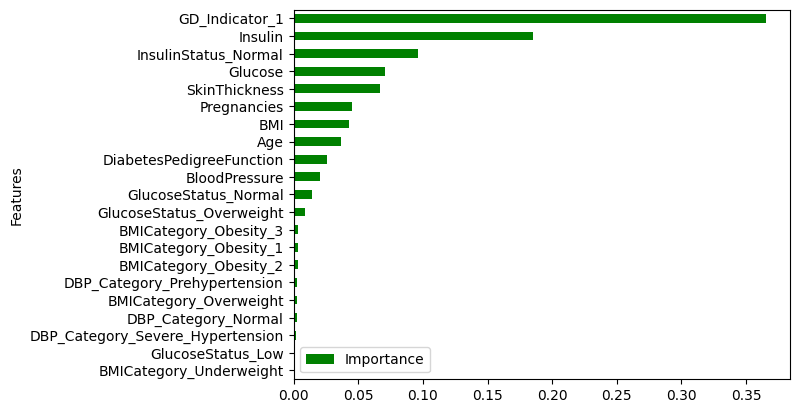

In [ ]:
hd.plot(kind='barh', color='green', x='Features')

Neural Network

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_X = scaler.fit_transform(train_X)
train_X = pd.DataFrame(train_X, columns = X.columns)
train_X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,BMICategory_Obesity_1,BMICategory_Obesity_2,...,BMICategory_Overweight,BMICategory_Underweight,InsulinStatus_Normal,GlucoseStatus_Low,GlucoseStatus_Normal,GlucoseStatus_Overweight,GD_Indicator_1,DBP_Category_Normal,DBP_Category_Prehypertension,DBP_Category_Severe_Hypertension
0,0.117647,0.354839,0.367347,0.178571,0.587525,0.376278,0.160120,0.000000,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.117647,0.303226,0.387755,0.357143,0.366197,0.186094,0.190863,0.016667,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.058824,0.690323,0.367347,0.357143,0.366197,0.161554,0.043126,0.016667,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.117647,0.658065,0.520408,0.446429,0.619718,0.190184,0.069172,0.116667,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.294118,0.922581,0.530612,0.357143,0.776660,0.519427,0.408198,0.533333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [ ]:
valid_X = scaler.fit_transform(valid_X)
valid_X = pd.DataFrame(valid_X, columns = X.columns)
valid_X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,BMICategory_Obesity_1,BMICategory_Obesity_2,...,BMICategory_Overweight,BMICategory_Underweight,InsulinStatus_Normal,GlucoseStatus_Low,GlucoseStatus_Normal,GlucoseStatus_Overweight,GD_Indicator_1,DBP_Category_Normal,DBP_Category_Prehypertension,DBP_Category_Severe_Hypertension
0,0.117647,0.793548,0.204082,0.410714,0.507042,0.552885,0.157173,0.116667,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.176471,0.432258,0.673469,0.089286,0.257545,0.163462,0.175589,0.133333,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.235294,0.303226,0.469388,0.446429,0.297787,0.238782,0.154604,0.016667,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.352941,0.374194,0.673469,0.571429,0.366197,0.280449,0.252248,0.116667,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.529412,0.651613,0.571429,0.696429,0.466801,0.315705,0.236403,0.316667,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [ ]:
#Original

NNmodel = MLPClassifier(hidden_layer_sizes = (18,9,3),
                   activation = "relu",
                   solver = 'sgd',
                   learning_rate = "adaptive",
                   learning_rate_init= 0.05,
                   max_iter=500, warm_start = True)

In [ ]:
NNmodel.fit(train_X, train_y)

MLPClassifier(hidden_layer_sizes=(18, 9, 3), learning_rate='adaptive',
              learning_rate_init=0.05, max_iter=500, solver='sgd',
              warm_start=True)

In [ ]:
predOG = NNmodel.predict(valid_X)
print(predOG)

[0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 1 0
 0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0
 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0
 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1
 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 1 0
 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0
 0 1 0 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0
 1 1 1 0 0 0 1 1 1 1 0 0 

In [ ]:
print(classification_report(valid_y, predOG))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       367
           1       0.99      0.97      0.98       185

    accuracy                           0.99       552
   macro avg       0.99      0.98      0.99       552
weighted avg       0.99      0.99      0.99       552



Confusion Matrix:
[[366   1]
 [  6 179]]


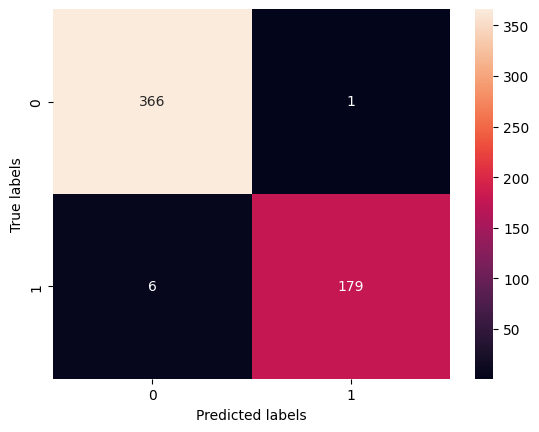

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,predOG)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
# Oversampling
overs = SMOTE(random_state=5)
X_train_OS, y_train_OS = overs.fit_resample(train_X, train_y)
print(y_train_OS.value_counts())
OS_nn = MLPClassifier(hidden_layer_sizes=(5,9,3),
                      activation="relu", solver='sgd',
                      learning_rate="adaptive",
                      learning_rate_init=0.05,
                      max_iter=500, warm_start=True)
OS_nn.fit(X_train_OS, y_train_OS)

Outcome
0    1444
1    1444
Name: count, dtype: int64


MLPClassifier(hidden_layer_sizes=(5, 9, 3), learning_rate='adaptive',
              learning_rate_init=0.05, max_iter=500, solver='sgd',
              warm_start=True)

In [ ]:
pred_NNOS = OS_nn.predict(valid_X)
print(pred_NNOS)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [ ]:
print(classification_report(valid_y, pred_NNOS))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       367
           1       0.34      1.00      0.50       185

    accuracy                           0.34       552
   macro avg       0.17      0.50      0.25       552
weighted avg       0.11      0.34      0.17       552



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
[[  0 367]
 [  0 185]]


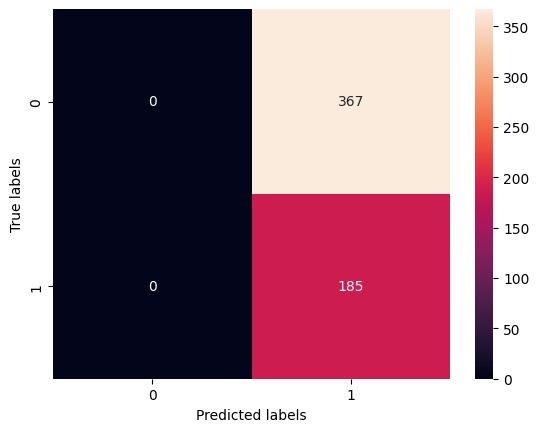

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,pred_NNOS)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
#Undersampling
unders = RandomUnderSampler(random_state=5)
X_train_US, y_train_US = unders.fit_resample(train_X, train_y)
US_nn = MLPClassifier(hidden_layer_sizes=(9,6,3),
                      activation="relu", solver='sgd',
                      learning_rate="adaptive",
                      learning_rate_init=0.05,
                      max_iter=500, warm_start=True)
US_nn.fit(X_train_US, y_train_US)

MLPClassifier(hidden_layer_sizes=(9, 6, 3), learning_rate='adaptive',
              learning_rate_init=0.05, max_iter=500, solver='sgd',
              warm_start=True)

In [ ]:
pred_NNUS = US_nn.predict(valid_X)
print(pred_NNUS)
print(classification_report(valid_y, pred_NNUS))

[0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 1 0
 0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0
 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0
 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1
 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 1 0
 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0
 0 1 0 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0
 1 1 1 0 0 0 1 1 1 1 0 0 

Confusion Matrix:
[[364   3]
 [  6 179]]


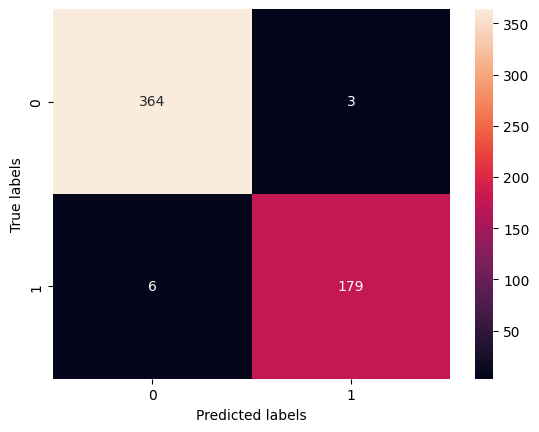

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y, pred_NNUS)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

**SVM**

In [ ]:
#Orginal

from sklearn.svm import SVC

# Support Vector Machine (SVM) Classifier
svm_model = SVC(kernel='rbf', random_state=1)
svm_model.fit(train_X, train_y)

svm_pred = svm_model.predict(valid_X)

print()
print(classification_report(valid_y, svm_pred))



              precision    recall  f1-score   support

           0       0.95      0.99      0.97       367
           1       0.98      0.90      0.94       185

    accuracy                           0.96       552
   macro avg       0.97      0.94      0.95       552
weighted avg       0.96      0.96      0.96       552



Confusion Matrix:
[[364   3]
 [ 19 166]]


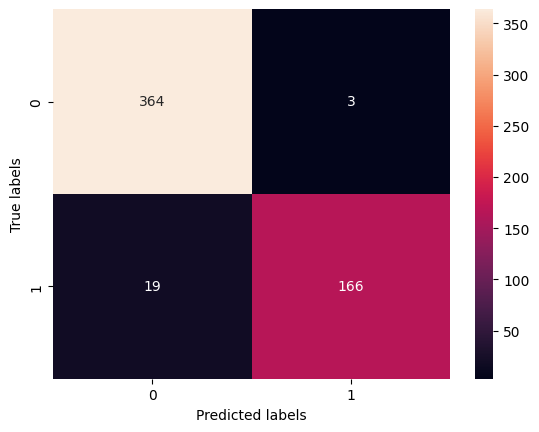

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,svm_pred)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
#Over sampling
svm_model = SVC(kernel='rbf', random_state=1)
svm_model.fit(X_train_OS, y_train_OS)

svm_pred = svm_model.predict(valid_X)

print()
print(classification_report(valid_y, svm_pred))



              precision    recall  f1-score   support

           0       0.97      0.99      0.98       367
           1       0.97      0.93      0.95       185

    accuracy                           0.97       552
   macro avg       0.97      0.96      0.96       552
weighted avg       0.97      0.97      0.97       552



Confusion Matrix:
[[362   5]
 [ 13 172]]


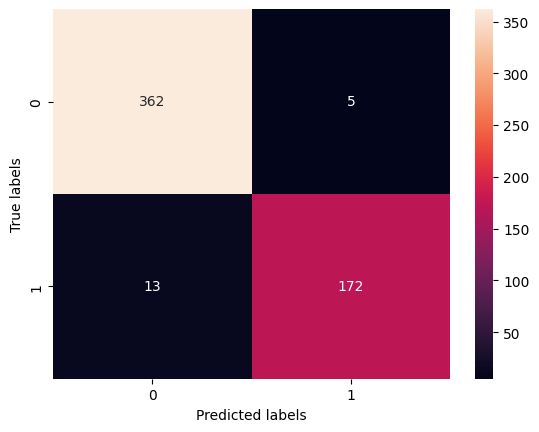

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y, svm_pred)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
#undersampling
svm_model = SVC(kernel='rbf', random_state=1)
svm_model.fit(X_train_US, y_train_US)

svm_pred = svm_model.predict(valid_X)

print()
print(classification_report(valid_y, svm_pred))



              precision    recall  f1-score   support

           0       0.96      0.96      0.96       367
           1       0.93      0.92      0.93       185

    accuracy                           0.95       552
   macro avg       0.95      0.94      0.95       552
weighted avg       0.95      0.95      0.95       552



Confusion Matrix:
[[354  13]
 [ 14 171]]


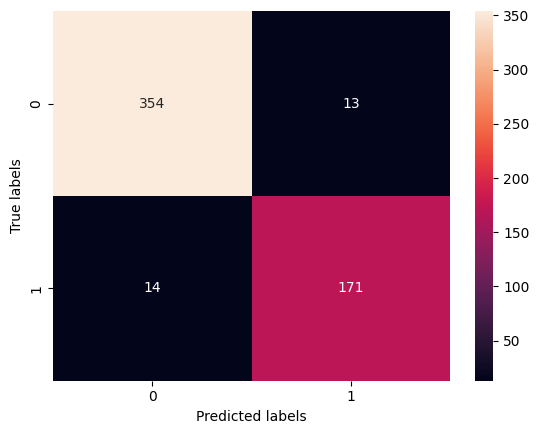

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y, svm_pred)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Discrinant analysis

In [ ]:
# Orginal

LDA = LinearDiscriminantAnalysis()

LDA.fit(train_X, train_y)

LDApred = LDA.predict(valid_X)

print()
print(classification_report(valid_y, LDApred))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96       367
           1       1.00      0.82      0.90       185

    accuracy                           0.94       552
   macro avg       0.96      0.91      0.93       552
weighted avg       0.95      0.94      0.94       552



Confusion Matrix:
[[367   0]
 [ 33 152]]


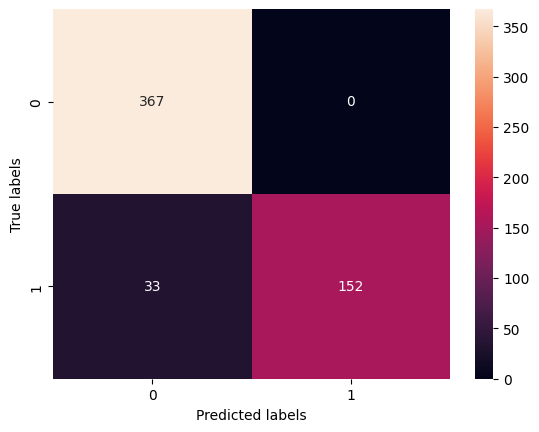

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,LDApred)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
# Oversampling

LDA_OS = LinearDiscriminantAnalysis()
LDA_OS.fit(X_train_OS, y_train_OS)

LDApred_OS = LDA_OS.predict(valid_X)

print()
print(classification_report(valid_y, LDApred_OS))


              precision    recall  f1-score   support

           0       0.92      0.99      0.95       367
           1       0.99      0.82      0.90       185

    accuracy                           0.94       552
   macro avg       0.95      0.91      0.93       552
weighted avg       0.94      0.94      0.93       552



Confusion Matrix:
[[365   2]
 [ 33 152]]


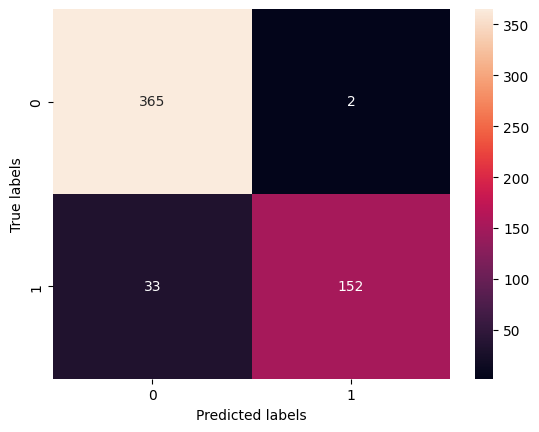

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,LDApred_OS)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
LDA_US = LinearDiscriminantAnalysis()
LDA_US.fit(X_train_US, y_train_US)

LDApred_US = LDA_US.predict(valid_X)

print()
print(classification_report(valid_y, LDApred_US))


              precision    recall  f1-score   support

           0       0.92      0.99      0.95       367
           1       0.99      0.82      0.90       185

    accuracy                           0.94       552
   macro avg       0.95      0.91      0.93       552
weighted avg       0.94      0.94      0.93       552



Confusion Matrix:
[[365   2]
 [ 33 152]]


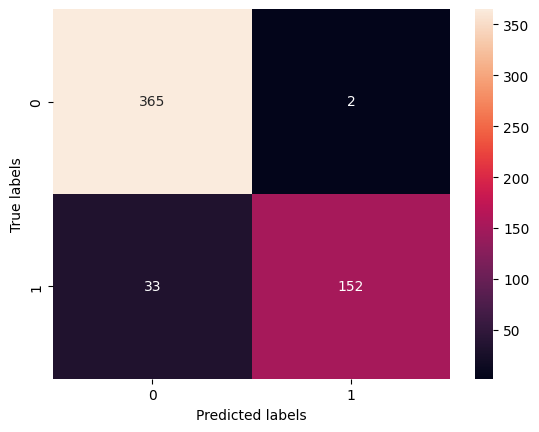

In [ ]:
# Confusion Matrix
cm = confusion_matrix(valid_y,LDApred_US)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()